#  The last 100 years of football, visualized

This notebook describes the code behind the project FootB, which web-scraps the final table of Serie A (Italy), Premier League (UK), League 1 (France), La Liga (Spain), Bundesliga (Germany) and looks at their overall statistics. 

## The data

The data come from the english version of wikipedia. The workflow looks something like this:
1. Load the webpage
2. Find the table we are interested in
3. Transform the data in a homogeneous usable format

Easy! Unfortunatelly there are some complications: leagues change name over the years (the Premier League was known as Football League before 1992); final tables can contain extra-columns or have differen column names depending on the year and/or on the league (the Football League has columns for home and away matches); some table entries can be of different type.

## Snippet of the code for Serie A (1985-86)
Here is the code to transform the final table for Serie A (1985-86) into a pandas dataframe. The code below will not work for all remaining years and all remaining leagues because the format changes depending on the webpage. The code working for all seasons and all leagues is [FootB.py](https://github.com/vincepota/FootB-stats) and it handles all the small differences between the wikipedia webpages under investigation. 

Here is first five entries of the table for Serie A (1985-86) as they look on wikipedia:
<img src="Serie_A.png" alt="Drawing" style="width: 700px;"/>

The columns we are interested in are: the Team name, the game played (Pld), won (W), lost (L), drawn (D), goals for (GF), goals against (GA), goal difference (GD) and points (Pts). Not all leagues used the same scoring system, so below we will redefine Pts using the most widely used system: 3 points for a victory, 1 point for drawn, 0 points for loss.

In [1]:
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np
import httplib2
import re

Most of the wikipedia tables we are dealing with will contain more than one table (list of coaches, results for every single game, etc.):

In [2]:
header = {'User-Agent': 'Mozilla/5.0'} # Needed to prevent 403 error on Wikipedia

wpage = 'https://en.wikipedia.org/wiki/1985-86_Serie_A'
req = urllib2.Request(wpage, headers = header)
page = urllib2.urlopen(req)
soup = BeautifulSoup(page, 'html5lib')
all_tables = soup.find_all('table')

where `all_tables` is a BeautifulSoup object which contains all the tables of our wikipedia page. 

We can loop through the tables and break the loop when we find a table containing `W` and `D` in the first row:

In [3]:
theone = [u'W', u'D']
for table in all_tables:
    all_rows = table.find_all('tr')
    lencols = len(all_rows[0].find_all('th')) 
    #Extract column names only
    cols = np.array([all_rows[0].find_all('th')[i].get_text().encode('ascii', 'ignore') for i in range(0, lencols)])
    if (theone[0] in cols) & (theone[1] in cols):
        rows = all_rows
        lenrows = len(rows)
        break
print cols

['P' 'Team' 'Pld' 'W' 'D' 'L' 'GF' 'GA' 'GD' 'Pts'
 'Promotion or relegation']


where `cols` is a list of all column names, whereas `table` is a BeautifulSoup object containing the html code of our table of interest. 

We will discard the Position column and create a new one from scratch using the dataframe index. We will also ignore the last column which can have different meanings for every year-season. Now we can create an empty dataframe and fill it:

In [4]:
columns = ['Team', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD'] 
df = pd.DataFrame(columns = columns, index = range(1, lenrows))
df.head(3)

,Team,Pld,W,D,L,GF,GA,GD
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
for i in range(1, lenrows):
    team = rows[i].find_all('td')
    df.Team.ix[i] = team[np.where(cols == 'Team')[0][0]].a.get_text().encode('ascii', 'ignore')
    for colnames in ['Pld','W', 'D', 'L', 'GF', 'GA','GD']:
        mask = np.where(cols == colnames)[0]
        df[colnames].ix[i] = int(team[mask[0]].get_text().encode('ascii', 'ignore'))
df.head(3)

,Team,Pld,W,D,L,GF,GA,GD
1,Juventus,30,18,9,3,43,17,26
2,Roma,30,19,3,8,51,27,24
3,Napoli,30,14,11,5,35,21,14


Let's add the year in which the season ended in the form of a pandas Period, the league name and the final position:

In [6]:
year = wpage.split('/')[-1].split('_')[0]
df['year'] = pd.Period(year.split('-')[0]) + 1
df['league'] = 'Serie A'
df['Pos'] = df.index
df.head(3)

,Team,Pld,W,D,L,GF,GA,GD,year,league,Pos
1,Juventus,30,18,9,3,43,17,26,1986,Serie A,1
2,Roma,30,19,3,8,51,27,24,1986,Serie A,2
3,Napoli,30,14,11,5,35,21,14,1986,Serie A,3


Transform the numerical columns into integers

In [7]:
coltmp = ['Pos', 'Pld', 'W', 'D', 'L', 'GF', 'GA','GD']
df[coltmp] = df[coltmp].astype(float).astype(int)
df.dtypes

Team      object
Pld        int64
W          int64
D          int64
L          int64
GF         int64
GA         int64
GD         int64
year      object
league    object
Pos        int64
dtype: object

Lastly, let's define the points `Pts` using the modern standard system, in which victory is 3 points, loss is 1 point and drawn is 0 points

In [8]:
df['Pts'] = df.W * 3. + df.D
df

,Team,Pld,W,D,L,GF,GA,GD,year,league,Pos,Pts
1,Juventus,30,18,9,3,43,17,26,1986,Serie A,1,63
2,Roma,30,19,3,8,51,27,24,1986,Serie A,2,60
3,Napoli,30,14,11,5,35,21,14,1986,Serie A,3,53
4,Fiorentina,30,10,13,7,29,23,6,1986,Serie A,4,43
5,Torino,30,11,11,8,31,26,5,1986,Serie A,5,44
6,Internazionale,30,12,8,10,36,33,3,1986,Serie A,6,44
7,Milan,30,10,11,9,26,24,2,1986,Serie A,7,41
8,Atalanta,30,7,15,8,27,26,1,1986,Serie A,8,36
9,Como,30,7,15,8,32,32,0,1986,Serie A,9,36
10,Verona,30,9,10,11,31,40,-9,1986,Serie A,10,37


That's it. We have transformed the final table for the Serie A (1985-86) into a pandas dataframe.

## All leagues, all years

Let's take this analysis a step forward and let's look at the statistics for 5 European leagues put together: Serie A, Permier League, League 1, La Liga and Bundesliga. The code to collect and concatenate the data can be found [here](https://github.com/vincepota/FootB-stats) and it is an extension of the procedure discussed above. Once it is run, the code produces a pandas dataframe, which I stored in [results.csv](https://github.com/vincepota/FootB-stats/blob/master/results.csv) for convenience. 

In [9]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot')

df = pd.read_csv('../results.csv')
df['year'] = df['year'].apply(pd.Period)
df.head(10)

,Team,Pld,W,D,L,GF,GA,GD,year,league,Pos,Pts
0,Athletic Bilbao,18,11,0,7,73,33,40,1931,La Liga,1,33
1,Racing de Santander,18,10,2,6,49,37,12,1931,La Liga,2,32
2,Real Sociedad,18,10,2,6,42,39,3,1931,La Liga,3,32
3,FC Barcelona,18,7,7,4,40,43,-3,1931,La Liga,4,28
4,Arenas Club de Getxo,18,8,2,8,35,38,-3,1931,La Liga,5,26
5,Real Madrid,18,7,4,7,24,27,-3,1931,La Liga,6,25
6,Real Unin,18,6,4,8,41,45,-4,1931,La Liga,7,22
7,Deportivo Alavs,18,5,4,9,25,39,-14,1931,La Liga,8,19
8,RCD Espaol,18,6,2,10,32,45,-13,1931,La Liga,9,20
9,CE Europa,18,6,1,11,23,38,-15,1931,La Liga,10,19


The number of teams is not the same for all leagues and it can change with years. 

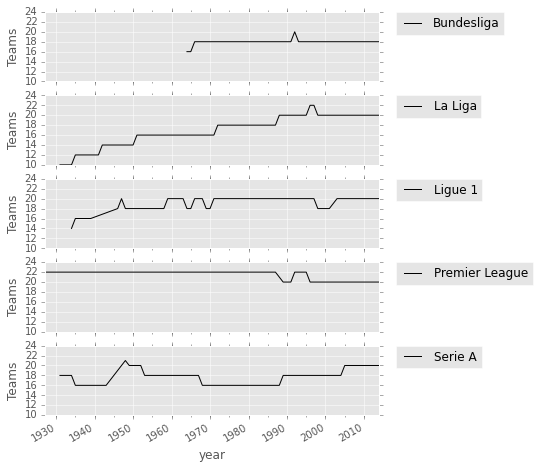

In [10]:
max_group = df.groupby(['year','league']).max().unstack().apply(pd.Series.interpolate)
ax = max_group['Pos'].plot(subplots=True,figsize=(6, 8), sharex=True)
for i in [0,1,2,3,4]:
    ax[i].set_ylim(10,24)
    ax[i].set_ylabel('Teams')
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

We can homogenise (normalize) the data by dividing some quantities of interest by the number of teams `TN` per league.

In [11]:
df['TN'] = df['Pld']/2. + 1 # Number of teams

df['Wn'] = df['W']/df['TN']
df['Dn'] = df['D']/df['TN']
df['Ln'] = df['L']/df['TN']
df['GFn'] = df['GF']/df['TN']
df['GAn'] = df['GA']/df['TN']
df['GDn'] = df['GD']/df['TN']

###Compare overall statistics
We can now look at how the normalized average number of vicoties and drawn varies as a function of years. Data are smoothed with a moving median filter of 5 years width to make trends clearer:

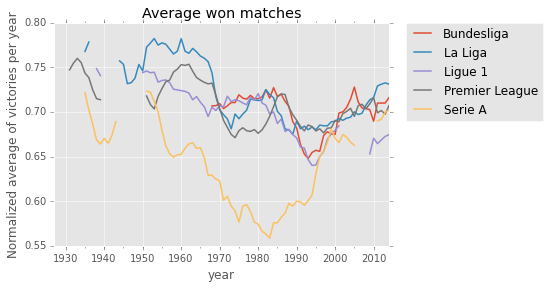

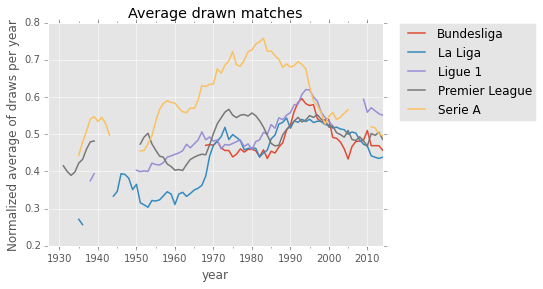

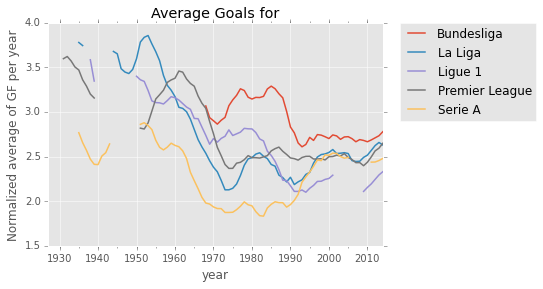

In [12]:
grouped = df.groupby(['year','league']).mean().unstack()

pd.rolling_mean(grouped['Wn'], 5).plot(lw = 1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Average won matches ')
plt.ylabel('Normalized average of victories per year')

pd.rolling_mean(grouped['Dn'], 5).plot(lw = 1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Average drawn matches')
plt.ylabel('Normalized average of draws per year')

pd.rolling_mean(grouped['GFn'], 5).plot(lw = 1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Average Goals for')
plt.ylabel('Normalized average of GF per year')

Serie A behaves differently from remaining leagues. Serie A teams score less and win less, consistent with the notorious defensive strategy (the 'catenaccio') of Serie A teams. In the 60s, all four leagues started to score less.

Taking the maximum value of each feature in each group, results are much more noisy, but reveal some interesting behaviours. La Liga saw a boost in the maximum number of victories in the 60s, in the 80s and right now is the best scoring and winning league.

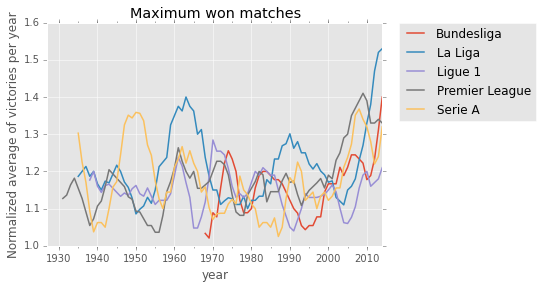

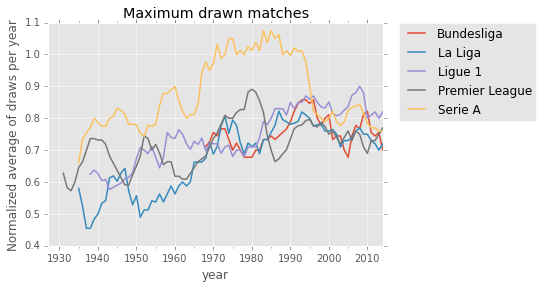

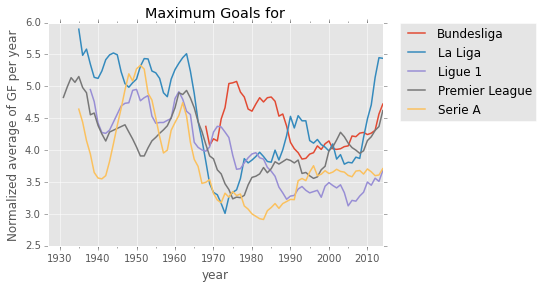

In [13]:
grouped = df.groupby(['year','league']).max().unstack().apply(pd.Series.interpolate)
# Do not fill up the gaps:
# grouped = df.groupby(['year','league']).max().unstack()

pd.rolling_mean(grouped['Wn'], 5).plot(lw = 1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Maximum won matches')
plt.ylabel('Normalized average of victories per year')

pd.rolling_mean(grouped['Dn'], 5).plot(lw = 1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Maximum drawn matches')
plt.ylabel('Normalized average of draws per year')

pd.rolling_mean(grouped['GFn'], 5).plot(lw = 1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Maximum Goals for')
plt.ylabel('Normalized average of GF per year')

### 2D distribution of Won vs Drawn

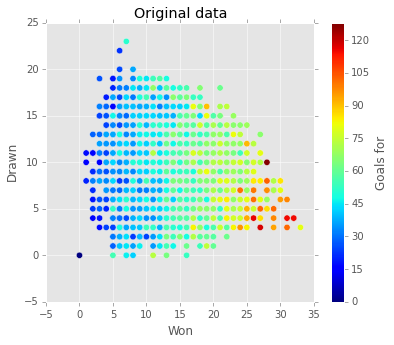

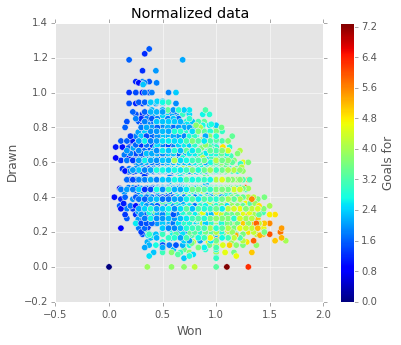

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(df.W,df.D,c=df.GF,s=40); plt.colorbar(label='Goals for')
plt.title('Original data')
plt.xlabel('Won')
plt.ylabel('Drawn')


plt.figure(figsize=(6,5))
plt.scatter(df.Wn,df.Dn,c=df.GFn,s=40); plt.colorbar(label='Goals for')
plt.title('Normalized data')
plt.xlabel('Won')
plt.ylabel('Drawn')

### Compare different teams
We can also look at the statistics of single teams, like Juventus vs Napoli:

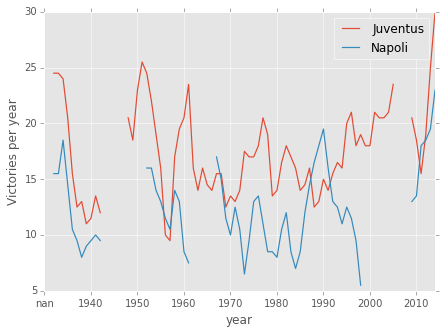

In [15]:
grouped = df.groupby('Team')
Juve = grouped.get_group('Juventus')
Napoli = grouped.get_group('Napoli')

s = pd.Series(np.arange(1930,2015).astype(str)).apply(pd.Period)
s.index = s
Juve.index = Juve.year
Juve = Juve.reindex(s, fill_value=np.nan)

merged = Juve.merge(Napoli, on='year', how='left');
merged[['W_x','W_y']] = pd.rolling_mean(merged[['W_x','W_y']],2)
#Plot
ax = merged.plot(x='year', y=['W_x','W_y'], lw=1.2,figsize=(7,5))
ax.legend(['Juventus','Napoli'])
ax.set_ylabel('Victories per year')

where you can see that Juve has always been superior to Napoli, except between 1986 and 1990 when Napoli won Serie A twice with Diego Armando Maradona.